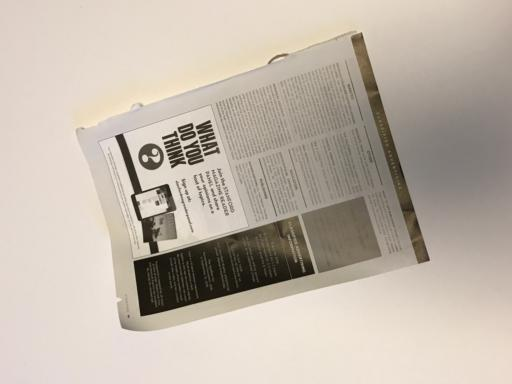

In [ ]:
from PIL import Image
import torch
import torch.nn as nn

img = Image.open('/content/drive/MyDrive/TrashNet Dataset/test/paper/paper1.jpg')
img

In [ ]:
print(img.size)
print(img.format)
print(img.mode)

(512, 384)
JPEG
RGB


In [ ]:
import os

print("test")
print("cardboard: ",len(os.listdir('/content/drive/MyDrive/TrashNet Dataset/test/cardboard')))
print("glass: ",len(os.listdir('/content/drive/MyDrive/TrashNet Dataset/test/glass')))
print("metal: ",len(os.listdir('/content/drive/MyDrive/TrashNet Dataset/test/metal')))
print("paper: ",len(os.listdir('/content/drive/MyDrive/TrashNet Dataset/test/paper')))
print("plastic: ",len(os.listdir('/content/drive/MyDrive/TrashNet Dataset/test/plastic')))
print("trash: ",len(os.listdir('/content/drive/MyDrive/TrashNet Dataset/test/trash')))
print('-----------------------------')
print("training")
print("cardboard: ",len(os.listdir('/content/drive/MyDrive/TrashNet Dataset/training/cardboard')))
print("glass: ",len(os.listdir('/content/drive/MyDrive/TrashNet Dataset/training/glass')))
print("metal: ",len(os.listdir('/content/drive/MyDrive/TrashNet Dataset/training/metal')))
print("paper: ",len(os.listdir('/content/drive/MyDrive/TrashNet Dataset/training/paper')))
print("plastic: ",len(os.listdir('/content/drive/MyDrive/TrashNet Dataset/training/plastic')))
print("trash: ",len(os.listdir('/content/drive/MyDrive/TrashNet Dataset/training/trash')))

test
cardboard:  99
glass:  99
metal:  99
paper:  99
plastic:  99
trash:  33
-----------------------------
training
cardboard:  305
glass:  403
metal:  312
paper:  496
plastic:  385
trash:  105


In [ ]:
from torchvision.transforms import v2

train_transforms = v2.Compose([
    v2.ToImage(),                          # 1. Convert PIL Image to Tensor/Image object
    v2.Resize((224, 224)),                 # make all images same size
    v2.RandomHorizontalFlip(p=0.5),        # randomly flip left-right
    v2.RandomRotation(degrees=15),         # small random rotation
    v2.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),      # handle lighting variations
    v2.ToDtype(torch.float32, scale=True), # convert [0–255] → [0–1]
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transforms = v2.Compose([
    v2.ToImage(),                          # 1. Convert PIL Image to Tensor/Image object
    v2.Resize((224,224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean = (0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [ ]:
from torchvision.datasets import ImageFolder

training_dataset = ImageFolder('/content/drive/MyDrive/TrashNet Dataset/training',transform=train_transforms)
test_dataset = ImageFolder('/content/drive/MyDrive/TrashNet Dataset/test',transform=test_transforms)

In [ ]:
from torch.utils.data import DataLoader

training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True,num_workers=2,pin_memory=True,drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=2,pin_memory=True)

In [ ]:
import torch.nn as nn
from collections import OrderedDict

class TrashNetTunable(nn.Module):
  def __init__(self,num_classes=6, dropout_rate=0.4, fc_units=256):
    super().__init__()

    self.feature_extraction = nn.Sequential(OrderedDict([
        # Block 1
        ("convolutional_layer1",nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1)),
        ("normalization_layer1",nn.BatchNorm2d(num_features=32)),
        ("relu1",nn.ReLU()),
        ("pooling_layer1",nn.MaxPool2d(kernel_size=2,stride=2)),

        # Block 2
        ("convolutional_layer2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)),
        ("normalization_layer2",nn.BatchNorm2d(num_features=64)),
        ("relu2",nn.ReLU()),
        ("pooling_layer2",nn.MaxPool2d(kernel_size=2,stride=2)),

        # Block 3
        ("convolutional_layer3",nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)),
        ("normalization_layer3",nn.BatchNorm2d(num_features=128)),
        ("relu3",nn.ReLU()),
    ]))

    # -------- Adaptive Pooling --------
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    self.classification = nn.Sequential(OrderedDict([
        ("input_layer",nn.Flatten()),
        ("hidden_layer1",nn.Linear(in_features=128,out_features=fc_units)),
        ("normalization_layer4",nn.BatchNorm1d(fc_units)),
        ("relu4",nn.ReLU()),
        ("drop_out1",nn.Dropout(p=dropout_rate)),
        ("hidden_layer2",nn.Linear(in_features=fc_units,out_features=128)),
        ("normalization_layer5",nn.BatchNorm1d(128)),
        ("relu5",nn.ReLU()),
        ("output_layer",nn.Linear(in_features=128,out_features=num_classes)),
    ]))

  def forward(self,x):
    x = self.feature_extraction(x)
    x = self.avgpool(x)
    x = self.classification(x)
    return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 16.1 MB/s eta 0:00:00


In [ ]:
import torch.optim as optim
import optuna

def objective(trial):
    # --- A. Suggest Hyperparameters ---
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.2, 0.6)
    fc_units = trial.suggest_int("fc_units", 128, 512, step=64)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    # --- B. Initialize Model ---
    model = TrashNetTunable(num_classes=6, dropout_rate=dropout, fc_units=fc_units).to(device)

    # --- C. Setup Optimizer ---
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    criterion = nn.CrossEntropyLoss()

    # --- D. Training Loop (Shortened for Tuning) ---
    # We train for fewer epochs (e.g., 10) to test viability quickly
    for epoch in range(10):
        model.train()
        for images, labels in training_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # --- E. Validation ---
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total

        # --- F. Pruning (Stop bad trials early) ---
        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize") # We want to MAXIMIZE accuracy
study.optimize(objective, n_trials=20) # Try 20 different combinations

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-12-31 12:15:47,711] A new study created in memory with name: no-name-76f426ab-345d-467a-b810-fc44e2d37833
[I 2025-12-31 12:19:18,120] Trial 0 finished with value: 0.6022727272727273 and parameters: {'lr': 0.00043651835930537457, 'dropout': 0.3203075115392259, 'fc_units': 128, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6022727272727273.
[I 2025-12-31 12:22:47,892] Trial 1 finished with value: 0.6401515151515151 and parameters: {'lr': 0.004825011925709284, 'dropout': 0.4776702115100629, 'fc_units': 512, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.6401515151515151.
[I 2025-12-31 12:26:21,739] Trial 2 finished with value: 0.6590909090909091 and parameters: {'lr': 0.0005121701675242826, 'dropout': 0.2803425506433124, 'fc_units': 320, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.6590909090909091.
[I 2025-12-31 12:29:55,052] Trial 3 finished with value: 0.571969696969697 and parameters: {'lr': 0.004856496277942338, 'dropout': 0.21226221916315058, 'fc_units': 320

Best trial:
  Value: 0.6590909090909091
  Params: 
    lr: 0.0005121701675242826
    dropout: 0.2803425506433124
    fc_units: 320
    optimizer: Adam


In [ ]:
model = TrashNetTunable()

### **Set the model to Evaluation Mode (Best for Summary)**

#### By calling model.eval(), the Batch Normalization layers stop trying to calculate batch statistics and instead use their "running buffers." This allows a batch size of 1 to pass through perfectly.

In [ ]:
pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model,input_size=(2,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
TrashNet                                 [2, 6]                    --
├─Sequential: 1-1                        [2, 128, 56, 56]          --
│    └─Conv2d: 2-1                       [2, 32, 224, 224]         896
│    └─BatchNorm2d: 2-2                  [2, 32, 224, 224]         64
│    └─ReLU: 2-3                         [2, 32, 224, 224]         --
│    └─MaxPool2d: 2-4                    [2, 32, 112, 112]         --
│    └─Conv2d: 2-5                       [2, 64, 112, 112]         18,496
│    └─BatchNorm2d: 2-6                  [2, 64, 112, 112]         128
│    └─ReLU: 2-7                         [2, 64, 112, 112]         --
│    └─MaxPool2d: 2-8                    [2, 64, 56, 56]           --
│    └─Conv2d: 2-9                       [2, 128, 56, 56]          73,856
│    └─BatchNorm2d: 2-10                 [2, 128, 56, 56]          256
│    └─ReLU: 2-11                        [2, 128, 56, 56]          --
├─Ad

In [ ]:
# model = TrashNet()
# x = torch.randn(2, 3, 224, 224)
# y = model(x)
# print(y.shape)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

epochs = 15

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in training_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # 1. Forward pass
        outputs = model(images)
        loss = loss_function(outputs, labels)

        # 2. Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(training_dataloader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    # Step the scheduler based on the loss
    scheduler.step(avg_loss)

cuda
Epoch [1/15], Loss: 1.0971
Epoch [2/15], Loss: 0.6712
Epoch [3/15], Loss: 0.5058
Epoch [4/15], Loss: 0.4223
Epoch [5/15], Loss: 0.3933
Epoch [6/15], Loss: 0.3563
Epoch [7/15], Loss: 0.2710
Epoch [8/15], Loss: 0.2734
Epoch [9/15], Loss: 0.2551
Epoch [10/15], Loss: 0.2245
Epoch [11/15], Loss: 0.2217
Epoch [12/15], Loss: 0.2191
Epoch [13/15], Loss: 0.1969
Epoch [14/15], Loss: 0.2225
Epoch [15/15], Loss: 0.1816


In [ ]:
model.eval()  # 1. switch to evaluation mode
correct = 0
total = 0

with torch.no_grad():   # 2. disable gradient tracking
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)             # 3. forward pass
        _, predicted = torch.max(outputs, 1) # 4. get predicted class

        total += labels.size(0)              # 5. total samples
        correct += (predicted == labels).sum().item()  # 6. correct predictions

accuracy = 100 * correct / total
print(accuracy)

88.82575757575758


In [ ]:
# Save to the same folder as your dataset
torch.save(model.state_dict(), '/content/drive/MyDrive/TrashNet_Final_Model.pth')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
model = TrashNetTunable(
    num_classes=6,
    fc_units=320,              # from Optuna
    dropout_rate=0.2803425506433124
).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005121701675242826,  # best lr
    weight_decay=1e-3          # L2 regularization
)

In [ ]:
epochs = 60

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in training_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(training_dataloader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

Epoch [1/60] - Loss: 1.3995
Epoch [2/60] - Loss: 1.2187
Epoch [3/60] - Loss: 1.1664
Epoch [4/60] - Loss: 1.1112
Epoch [5/60] - Loss: 1.0733
Epoch [6/60] - Loss: 1.0557
Epoch [7/60] - Loss: 1.0038
Epoch [8/60] - Loss: 0.9662
Epoch [9/60] - Loss: 0.9533
Epoch [10/60] - Loss: 0.9277
Epoch [11/60] - Loss: 0.9070
Epoch [12/60] - Loss: 0.8907
Epoch [13/60] - Loss: 0.8645
Epoch [14/60] - Loss: 0.8721
Epoch [15/60] - Loss: 0.8598
Epoch [16/60] - Loss: 0.8347
Epoch [17/60] - Loss: 0.8245
Epoch [18/60] - Loss: 0.8165
Epoch [19/60] - Loss: 0.7888
Epoch [20/60] - Loss: 0.7889
Epoch [21/60] - Loss: 0.7778
Epoch [22/60] - Loss: 0.7486
Epoch [23/60] - Loss: 0.7780
Epoch [24/60] - Loss: 0.7572
Epoch [25/60] - Loss: 0.7003
Epoch [26/60] - Loss: 0.7252
Epoch [27/60] - Loss: 0.7369
Epoch [28/60] - Loss: 0.6980
Epoch [29/60] - Loss: 0.7020
Epoch [30/60] - Loss: 0.7037
Epoch [31/60] - Loss: 0.6937
Epoch [32/60] - Loss: 0.7035
Epoch [33/60] - Loss: 0.6559
Epoch [34/60] - Loss: 0.6674
Epoch [35/60] - Loss: 0

In [ ]:
print("hi")

hi


In [ ]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 85.23%
